# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [9]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv

np.warnings = warnings

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv')
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [10]:
# # load transaction dataset
# df_patient = pd.read_csv('../data/PATIENTS.csv')
# df_admission = pd.read_csv('../data/ADMISSIONS.csv')
# df_diagnosis = pd.read_csv('../data/DIAGNOSES_ICD.csv')
# df_labvent = pd.read_csv('../data/LABEVENTS.csv')
# df_microbiology = pd.read_csv('../data/MICROBIOLOGYEVENTS.csv')

# # load description tables
# df_desc_icd = pd.read_csv('../data/D_ICD_DIAGNOSES.csv')
# df_desc_item = pd.read_csv('../data/D_ITEMS.csv')

## 1.1 Data Cleaning

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [11]:
# load transaction dataset
df_patients = pd.read_csv('../data/PATIENTS.csv')
df_admissions = pd.read_csv('../data/ADMISSIONS.csv')
df_diagnoses_icd = pd.read_csv('../data/DIAGNOSES_ICD.csv')
df_labevents = pd.read_csv('../data/LABEVENTS.csv')
df_microbiologyevents = pd.read_csv('../data/MICROBIOLOGYEVENTS.csv')

# load description tables
df_desc_icd = pd.read_csv('../data/D_ICD_DIAGNOSES.csv')
df_desc_labitems = pd.read_csv('../data/D_LABITEMS.csv')
df_desc_items = pd.read_csv('../data/D_ITEMS.csv')

In [12]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [13]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [14]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd[(df_diagnoses_icd['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

#function to save df to csv file
def save_csv(df, filename):
    filepath = Path(filename)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath, index=False)

In [16]:
# create demographic df and save to csv file for future load
try:
    df_demographic = pd.read_csv('../data/demographic.csv')
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = ((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365).dt.days
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

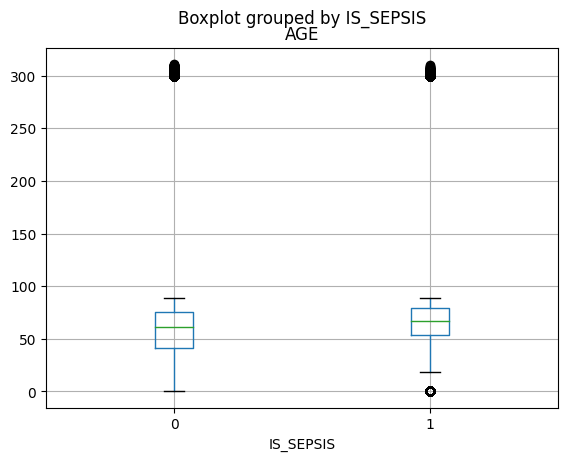

In [17]:
# plotting the age of admissions
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

In [18]:
# List all Parquet files in the output folder
output_dir = 'data/labevents_transform_sepsis_parquet'
parquet_files = [f'{output_dir}/{file}' for file in os.listdir(output_dir) if file.endswith('.parquet')]

# Read all Parquet files into a list of DataFrames
dfs = [pd.read_parquet(file) for file in parquet_files]

# Concatenate the list of DataFrames into a single DataFrame
df_labevents_sepsis = pd.concat(dfs, ignore_index=True)
df_labevents_sepsis.columns = df_labevents_sepsis.columns.str.upper()

FileNotFoundError: [Errno 2] No such file or directory: 'data/labevents_transform_sepsis_parquet'

## 1.2 Data Exploration

In [20]:
# Working on the demographic data of patients
df_demographic.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,EXPIRE_FLAG,AGE,IS_SEPSIS
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,F,2131-05-07,0,64,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,M,2082-07-17,0,71,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,NaN,BRAIN MASS,0,1,M,2082-07-17,0,75,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,M,2100-05-31,0,39,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,M,2101-11-21,0,58,0


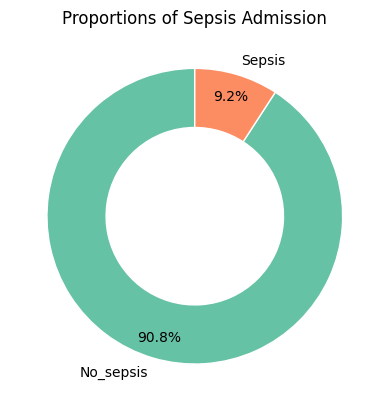

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Counting the number of instance in each class
label_counts = df_demographic["IS_SEPSIS"].value_counts()

# Plotting the counts in a donut chart
fig_donut, ax_donut = plt.subplots()
label_dict = {0:"No_sepsis", 1: "Sepsis"}
long_labels = df_demographic['IS_SEPSIS'].map(label_dict)
colors = sns.color_palette("Set2")
ax_donut.pie(label_counts, labels=long_labels.unique(), colors=colors,
             autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Proportions of Sepsis Admission")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig_donut.gca().add_artist(centre_circle)
plt.show()

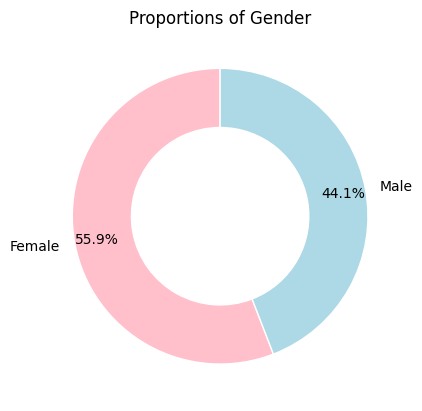

In [55]:
gender_counts = df_demographic["GENDER"].value_counts()

# Plotting the counts in a donut chart
gender_fig_donut, gender_ax_donut = plt.subplots()
gender_dict = {"M":"Male", "F": "Female"}
gender_long_labels = df_demographic['GENDER'].map(gender_dict)
gender_colors = ["pink",'lightblue']
gender_ax_donut.pie(gender_counts, labels=gender_long_labels.unique(), colors=gender_colors,
             autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
gender_ax_donut.set_title("Proportions of Gender")
centre_circle = plt.Circle((0,0),0.60,fc='white')
gender_fig_donut.gca().add_artist(centre_circle)
plt.show()

In [86]:
# Define bin edges to include 0 and 320
bin_edges = list(range(0, 321, 20))  # Bins every 20 years from 0 to 320 (inclusive)

# Create age bins with right=False
df_demographic['AgeGroup'] = pd.cut(df_demographic['AGE'], bins=bin_edges, labels=[f"{i}-{i+19}" for i in range(0, 320, 20)], right=False)

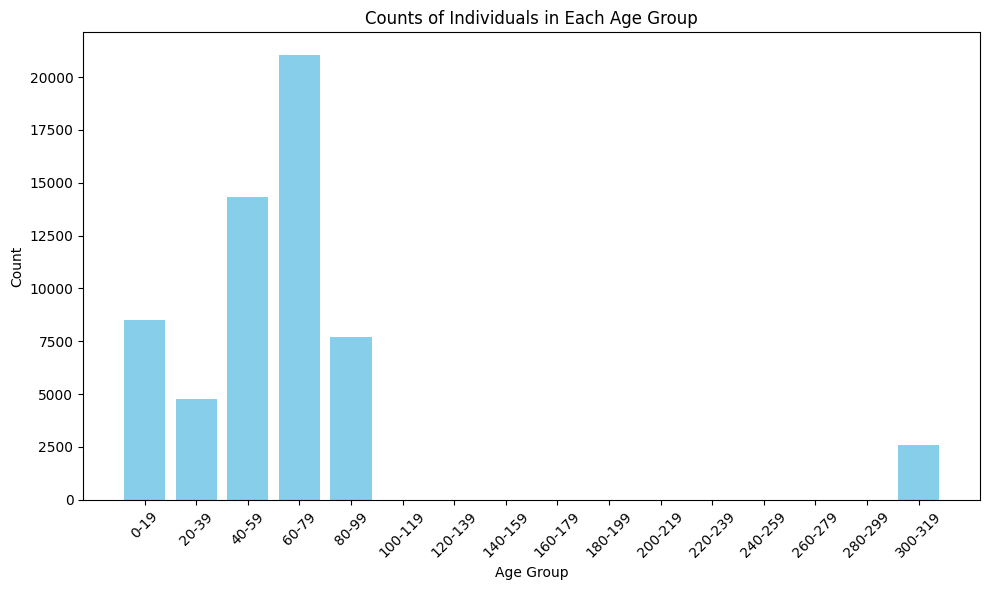

In [88]:
# Calculate the counts for each age group
age_group_counts = df_demographic['AgeGroup'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(age_group_counts.index, age_group_counts.values, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Counts of Individuals in Each Age Group')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

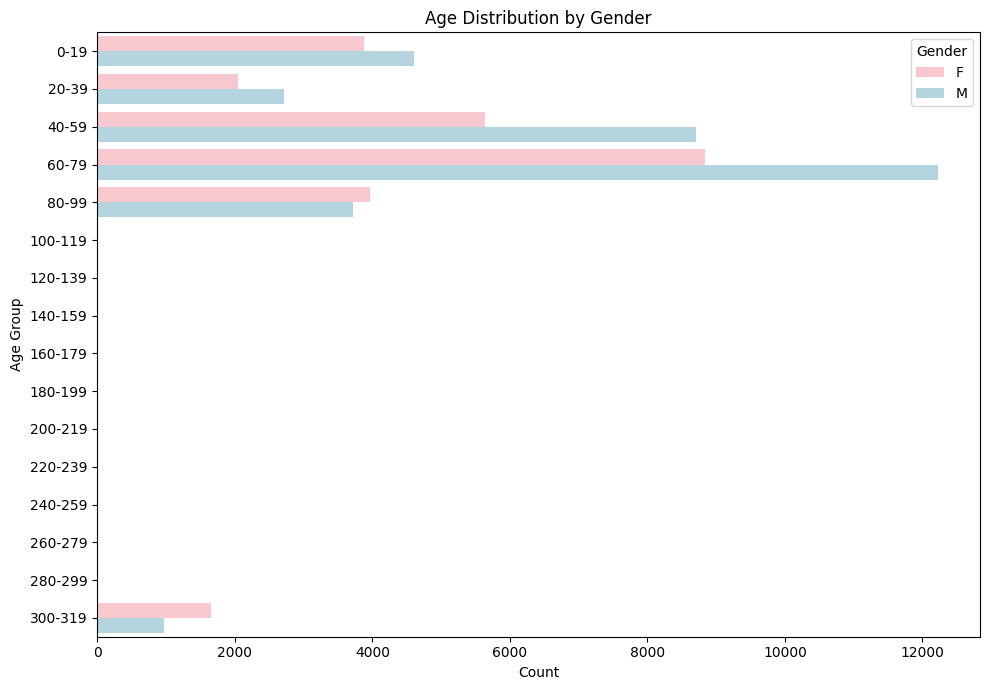

In [96]:
# Sort the DataFrame by 'AgeGroup' column
df_demographic.sort_values(by='AgeGroup', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Count the number of observations for each AgeGroup and GENDER
age_gender_counts = df_demographic.groupby(['AgeGroup', 'GENDER']).size().reset_index(name='Count')

# Create a side-by-side barplot
sns.barplot(data=age_gender_counts, x='Count', y='AgeGroup', hue='GENDER', palette={"F": "pink", "M": "lightblue"})

# Set labels, title, and legend
ax.set_xlabel('Count')
ax.set_ylabel('Age Group')
ax.set_title('Age Distribution by Gender')
ax.legend(title='Gender')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

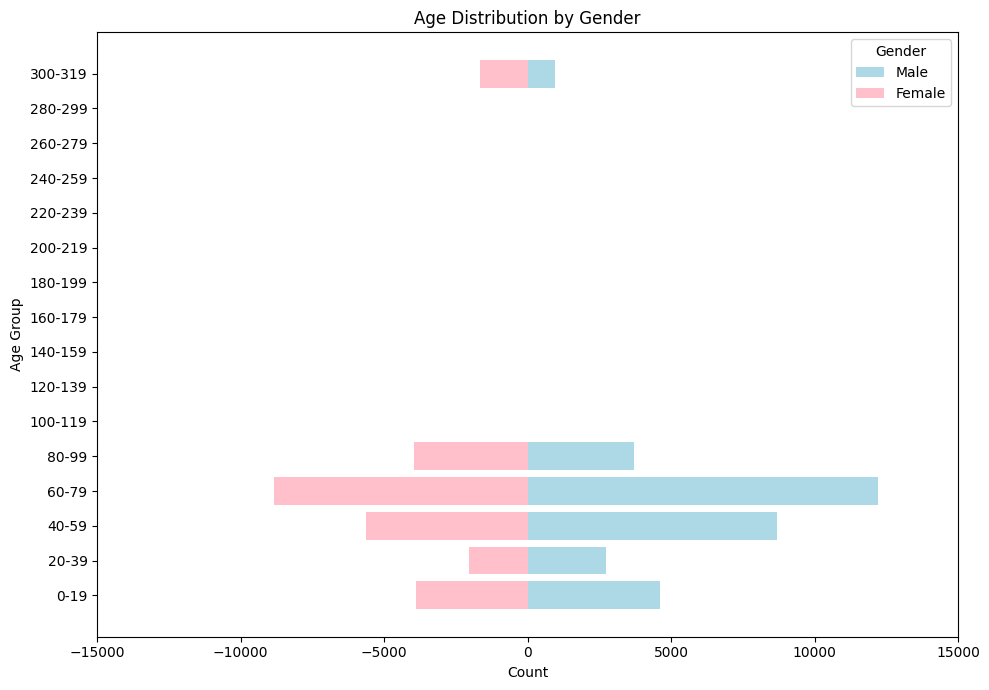

In [102]:
# Sort the DataFrame by 'AgeGroup' column
df_demographic.sort_values(by='AgeGroup', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Count the number of observations for each AgeGroup and GENDER
age_gender_counts = df_demographic.groupby(['AgeGroup', 'GENDER']).size().unstack().reset_index()

# Create side-by-side bars for males and females with opposite directions
ax.barh(age_gender_counts['AgeGroup'], age_gender_counts['M'], color="lightblue", label='Male')
ax.barh(age_gender_counts['AgeGroup'], -age_gender_counts['F'], color="pink", label='Female')

# Set labels, title, and legend
ax.set_xlabel('Count')
ax.set_ylabel('Age Group')
ax.set_title('Age Distribution by Gender')
ax.legend(title='Gender')

# Set symmetric x-axis limits
ax.set_xlim(-15000, 15000)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

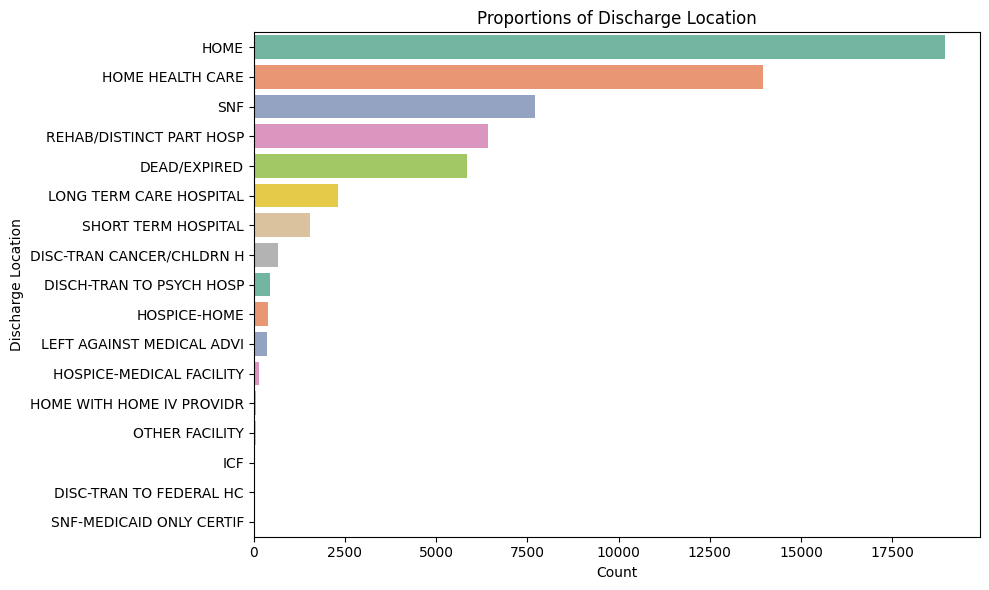

In [104]:
# Count the number of instances for each discharge location
discharge_location_counts = df_demographic["DISCHARGE_LOCATION"].value_counts()

# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the chart
colors = sns.color_palette("Set2")

# Create a bar chart for discharge locations
sns.barplot(x=discharge_location_counts.values, y=discharge_location_counts.index, palette=colors, ax=ax)

# Set labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Discharge Location')
ax.set_title('Proportions of Discharge Location')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

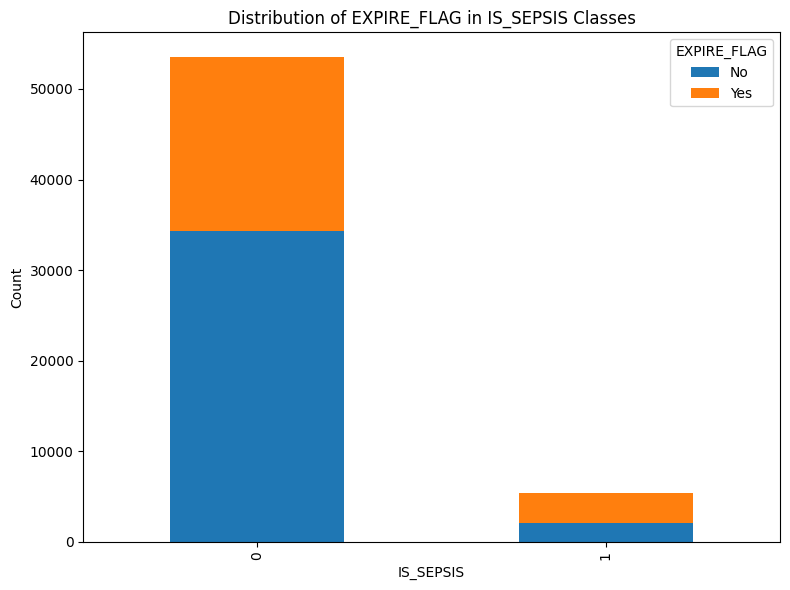

In [106]:
# Create a cross-tabulation of IS_SEPSIS and EXPIRE_FLAG
crosstab = pd.crosstab(df_demographic["IS_SEPSIS"], df_demographic["EXPIRE_FLAG"])

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
crosstab.plot(kind="bar", stacked=True, ax=ax)

# Set labels and title
ax.set_xlabel('IS_SEPSIS')
ax.set_ylabel('Count')
ax.set_title('Distribution of EXPIRE_FLAG in IS_SEPSIS Classes')

# Add a legend
ax.legend(title='EXPIRE_FLAG', labels=['No', 'Yes'])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

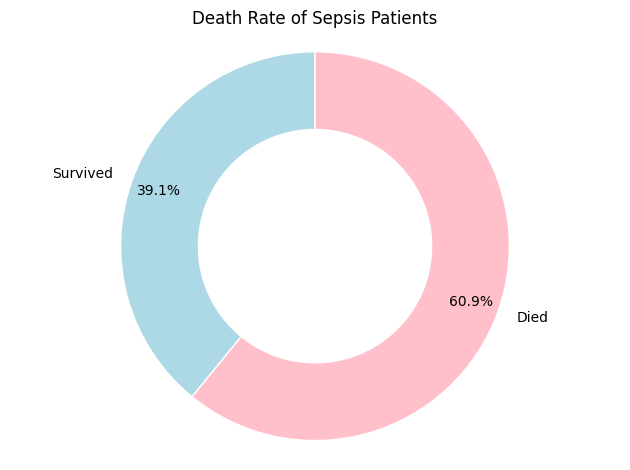

In [109]:
# Filter the DataFrame for sepsis patients (IS_SEPSIS=1) who have died (EXPIRE_FLAG=1)
sepsis_expire_counts = df_demographic[(df_demographic['IS_SEPSIS'] == 1) & (df_demographic['EXPIRE_FLAG'] == 1)]

# Count the number of instances
death_count = len(sepsis_expire_counts)

# Count the number of sepsis patients
sepsis_patient_count = len(df_demographic[df_demographic['IS_SEPSIS'] == 1])

# Calculate the survival rate
survival_rate = (sepsis_patient_count - death_count) / sepsis_patient_count
death_rate = 1 - survival_rate

# Create a figure and axis for the donut chart
fig_donut, ax_donut = plt.subplots()

# Define labels and colors for the chart
labels = ['Survived', 'Died']
colors = ['lightblue', 'pink']

# Plot the counts in a donut chart
ax_donut.pie([survival_rate, death_rate], labels=labels, colors=colors,
              autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Death Rate of Sepsis Patients")

# Create a white circle in the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig_donut.gca().add_artist(centre_circle)

# Adjust layout and show the plot
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()


## 1.3 Feature Selection

# 2.Sepsis Risk Predicting Model Implementation

## 2.1 Logistics Regression Model

## 2.2 Random Forest Model

## 2.3 Gradient Boosted Model

## 2.4 LSTM Model

## 2.5 LSTM + Attention Model

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation